# Neural Network In Pytorch
This project aims to get familiarized with building the whole pipeline of deep learning in Pytorch to perform classification and test it out on the CIFAR-10 dataset. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/MyDrive/'Colab '/PytorchExample

In [ ]:
! pip install torch_utils

## Design the Neural Network and Data Preparation


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import cuda
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, sampler
import torch.nn.functional as F
from torch_utils import AverageMeter
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import inf


from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torch import optim, cuda, Tensor
import tqdm

# Data science tools
import numpy as np

import os

# Image manipulations
from PIL import Image
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Network Design
Define a class for the network. The network should include two linear layer, one Relu layer, and one dropout layer.

In [ ]:
# Define model
class bmodel(nn.Module):
    def __init__(self, input_d, hidden_d, output_d):
        super().__init__()
        # Define all the layers that are needed in the network
        self.fc1 = nn.Linear(input_d, hidden_d, dtype=torch.float32)
        self.fc2 = nn.Linear(hidden_d, output_d, dtype=torch.float32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Design the network structure 
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [ ]:
# Create a small net and some toy data to check implementations.
input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return bmodel(input_size, hidden_size, num_classes)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

toy_model = init_toy_model()

if train_on_gpu:
    toy_model.cuda()

train_X, train_Y = init_toy_data()
validation_X, validation_Y = init_toy_data()


bmodel(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
# Check whether there is a gpu for cuda
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
else:
    multi_gpu = False
print(train_on_gpu,multi_gpu)

Train on gpu: True
1 gpus detected.
True False


### Data Preparation
Organize the data before loading them into the network.

In [ ]:
batch_size = 1

data = {
    'train': TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).long()),
    'valid': TensorDataset(torch.from_numpy(validation_X).float(), torch.from_numpy(validation_Y).long())
}

dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=10),
    'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=False, num_workers=10)
}

trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape


(torch.Size([1, 4]), torch.Size([1]))

### Setting Learning Parameters
In the training process, need to set up the loss function and optimizer tool.

In [ ]:
# Set up criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(toy_model.parameters(), lr=0.001) 

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([10, 4])
torch.Size([10])
torch.Size([3, 10])
torch.Size([3])


## Build the Training Pipeline

In [ ]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=10,
          print_every=1):


    """Train a PyTorch Model

        
    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

        if train_on_gpu:
           model = model.cuda()

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()

        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):

            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
          
            # Forward path
            output = model(data)

            # Loss function 
            loss = criterion(output, target)

            # Backward path (backpropagation)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))

            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():

                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                      data, target = data.cuda(), target.cuda()

                    # Forward path
                    output = model(data)

                    # Validation loss computation
                    loss = criterion(output, target)

                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)


                # Calculate average losses and Calculate average accuracy
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model 
                    torch.save(model.state_dict(), save_file_name)

                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))

                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    
    return model, history


## Train the network

### Train a Network With Toy Data


In [ ]:
from timeit import default_timer as timer
save_file_name = f'toy_model_best_model.pt'
train_on_gpu = cuda.is_available()

model, history = train(
    toy_model,
    criterion,
    optimizer,
    dataloaders['train'], 
    dataloaders['valid'],
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=500,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.5549 	Validation Loss: 1.1269
		Training Accuracy: 20.00%	 Validation Accuracy: 40.00%

Epoch: 1 	Training Loss: 1.6768 	Validation Loss: 1.1110
		Training Accuracy: 20.00%	 Validation Accuracy: 40.00%

Epoch: 2 	Training Loss: 1.2904 	Validation Loss: 1.0908
		Training Accuracy: 60.00%	 Validation Accuracy: 40.00%

Epoch: 3 	Training Loss: 1.4178 	Validation Loss: 1.0644
		Training Accuracy: 20.00%	 Validation Accuracy: 40.00%

Epoch: 4 	Training Loss: 1.8573 	Validation Loss: 1.0408
		Training Accuracy: 20.00%	 Validation Accuracy: 40.00%

Epoch: 5 	Training Loss: 1.2273 	Validation Loss: 1.0123
		Training Accuracy: 40.00%	 Validation Accuracy: 40.00%

Epoch: 6 	Training Loss: 1.1456 	Validation Loss: 0.9891
		Training Accuracy: 40.00%	 Validation Accuracy: 40.00%

Epoch: 7 	Training Loss: 1.7153 	Validation Loss: 0.9594
		Training Accuracy: 0.00%	 Validation Accuracy: 40.00%

Epoch: 8 	Training Loss: 1.1328 	Validation Los

Check the losses and accuracy during the training.

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

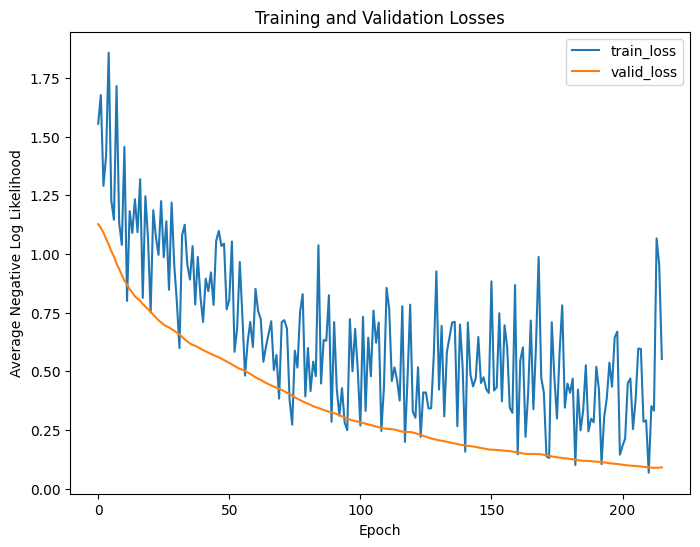

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

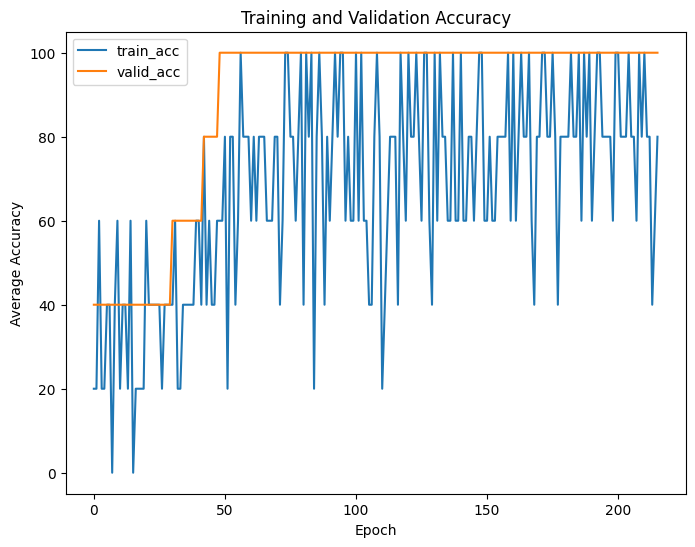

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

### Train a Network With Cifar-10 Data
Use the Cifar-10 dataset to train the model. 

In [ ]:
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier.   
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = './datasets/'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
train_X, train_Y, validation_X, validation_Y, test_X, test_Y = get_CIFAR10_data()
print('Train data shape: ', train_X.shape)
print('Train labels shape: ', train_Y.shape)
print('Validation data shape: ', validation_X.shape)
print('Validation labels shape: ', validation_Y.shape)
print('Test data shape: ', test_X.shape)
print('Test labels shape: ', test_Y.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


Since Cifar-10 has a larger size of data, which is harder to train, increase network parameters to solve. 


In [ ]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10

model = bmodel(input_size, hidden_size, num_classes)

In [ ]:
# Datasets from folders
batch_size = 16
# Transfer the data from numpy to tensor
data = {
    'train': TensorDataset(torch.from_numpy(train_X.reshape(-1, input_size)).float(), torch.from_numpy(train_Y).long()),
    'valid': TensorDataset(torch.from_numpy(validation_X.reshape(-1, input_size)).float(), torch.from_numpy(validation_Y).long())
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=10),
    'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=False, num_workers=10)
}


# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([16, 3072]), torch.Size([16]))

In [ ]:
# Set up criterion and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)


torch.Size([50, 3072])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [ ]:
from timeit import default_timer as timer
save_file_name = f'cifar_model_best_model.pt'
train_on_gpu = cuda.is_available()

model, history = train(model,
    criterion,
    optimizer,
    dataloaders['train'], 
    dataloaders['valid'],
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=500,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 9.0861 	Validation Loss: 2.4744
		Training Accuracy: 21.97%	 Validation Accuracy: 21.10%

Epoch: 1 	Training Loss: 3.8432 	Validation Loss: 3.1817
		Training Accuracy: 18.75%	 Validation Accuracy: 23.70%

Epoch: 2 	Training Loss: 4.5587 	Validation Loss: 4.5779
		Training Accuracy: 17.93%	 Validation Accuracy: 19.90%

Epoch: 3 	Training Loss: 4.7410 	Validation Loss: 3.7158
		Training Accuracy: 17.74%	 Validation Accuracy: 20.90%

Early Stopping! Total epochs: 3. Best epoch: 0 with loss: 2.47 and acc: 20.90%
61.03 total seconds elapsed. 15.26 seconds per epoch.


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

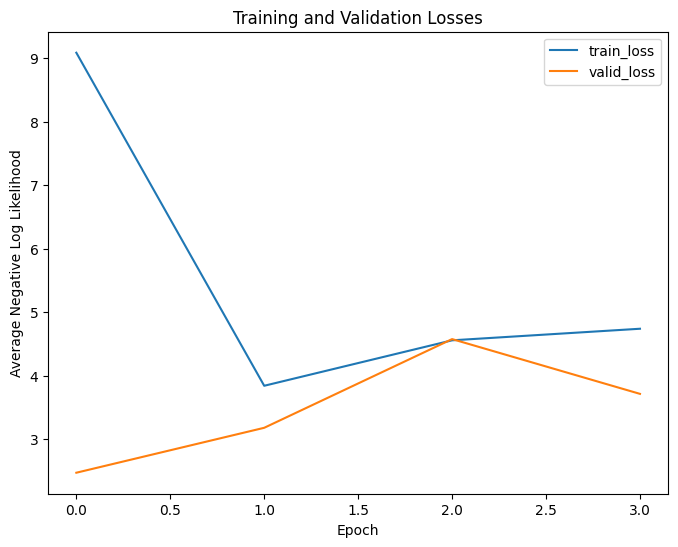

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

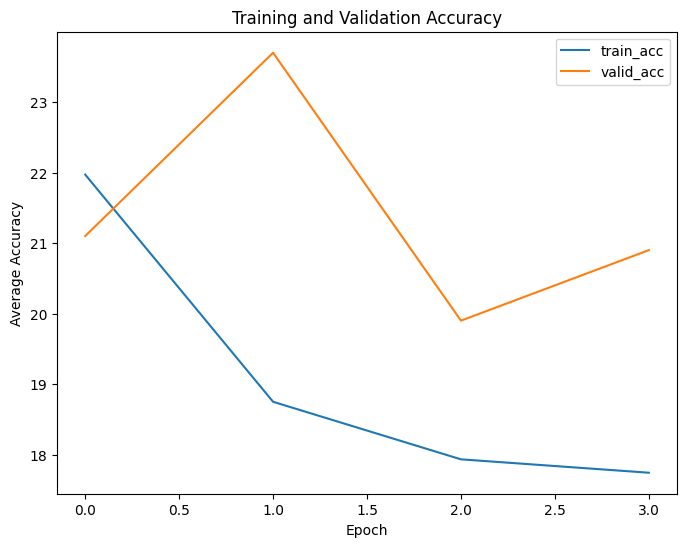

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

##Improve The Performance


In [ ]:
# Updated to include batch normalization layers.
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from timeit import default_timer as timer
from torchvision import transforms


class bmodel(nn.Module):
    def __init__(self, input_d, hidden_d, output_d):
        super().__init__()

        self.fc1 = nn.Linear(input_d, hidden_d)
        self.bn1 = nn.BatchNorm1d(hidden_d)
        self.fc2 = nn.Linear(hidden_d, hidden_d)
        self.bn2 = nn.BatchNorm1d(hidden_d)
        self.fc3 = nn.Linear(hidden_d, output_d)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x


In [ ]:
# Use the transformations with data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:13<00:00, 12909321.41it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# Added scheduler 
def train(model,
          criterion,
          optimizer,
          scheduler, 
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=10,
          print_every=1):


    """Train a PyTorch Model

        
    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

        if train_on_gpu:
           model = model.cuda()

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()

        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            
            # Tensors to gpu, both model parameters, data, and target need to be tensors.
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            
            # Forward path
            output = model(data)


            # Loss function 
            loss = criterion(output, target)

            # Backward path (backpropagation)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))

            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():

                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                      data, target = data.cuda(), target.cuda()

                    # Forward path
                    output = model(data)

                    # Validation loss computation
                    loss = criterion(output, target)

                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)


                # Calculate average losses and Calculate average accuracy
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                scheduler.step(valid_loss)

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model 
                    torch.save(model.state_dict(), save_file_name)


                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))

                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    
    return model, history

In [ ]:
# Instantiate the model, criterion, optimizer, and learning rate scheduler
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10

model = bmodel(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

In [ ]:
# Datasets from folders
batch_size = 16
# Transfer the data from numpy to tensor
data = {
    'train': TensorDataset(torch.from_numpy(train_X.reshape(-1, input_size)).float(), torch.from_numpy(train_Y).long()),
    'valid': TensorDataset(torch.from_numpy(validation_X.reshape(-1, input_size)).float(), torch.from_numpy(validation_Y).long())
}


# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=10),
    'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=False, num_workers=10)
}

# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

# Set up your criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

from timeit import default_timer as timer
save_file_name = f'cifar_model_best_model.pt'
train_on_gpu = cuda.is_available()

model, history = train(model,
    criterion,
    optimizer,
    scheduler,
    dataloaders['train'], 
    dataloaders['valid'],
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=500,
    print_every=1)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(torch.Size([16, 3072]), torch.Size([16]))

torch.Size([50, 3072])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])
Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.7453 	Validation Loss: 1.5131
		Training Accuracy: 37.66%	 Validation Accuracy: 45.50%

Epoch: 1 	Training Loss: 1.5937 	Validation Loss: 1.4640
		Training Accuracy: 43.21%	 Validation Accuracy: 47.40%

Epoch: 2 	Training Loss: 1.5290 	Validation Loss: 1.4244
		Training Accuracy: 45.38%	 Validation Accuracy: 48.40%

Epoch: 3 	Training Loss: 1.4902 	Validation Loss: 1.3761
		Training Accuracy: 47.14%	 Validation Accuracy: 50.10%

Epoch: 4 	Training Loss: 1.4573 	Validation Loss: 1.3613
		Training Accuracy: 47.97%	 Validation Accuracy: 51.00%

Epoch: 5 	Training Loss: 1.4350 	Validation Loss: 1.3547
		Training Accuracy: 48.78%	 Validation Accuracy: 51.30%

Epoch: 6 	Training Loss: 1.4145 	Validation Loss: 1.3455
		Training Accuracy: 49.69%	 Valida

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

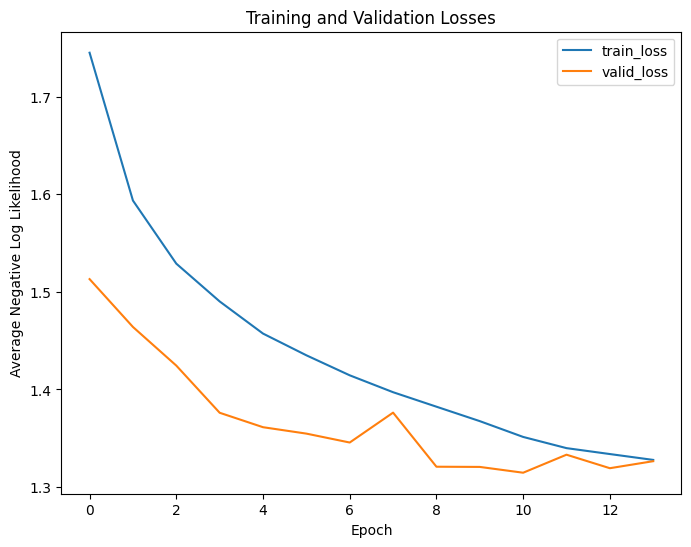

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

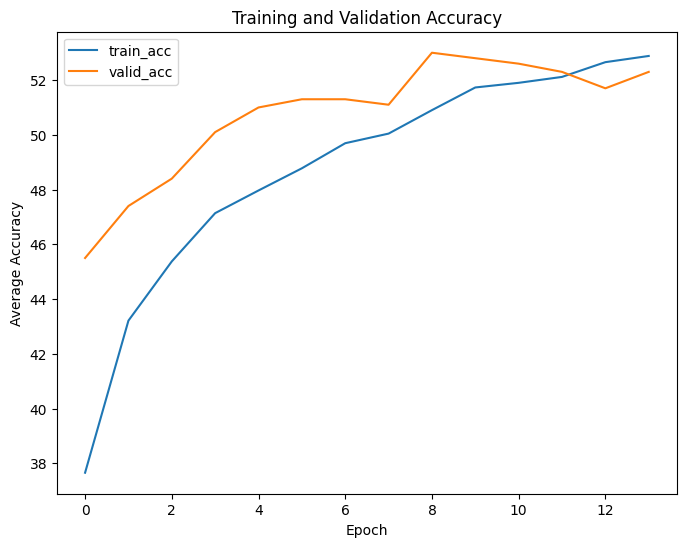

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()